In [ ]:
import numpy as np
import pandas as pd
from cv2 import imread, normalize
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten


In [ ]:
train_folder = "background_folder/images_train/"
val_folder = 'background_folder/images_validation/'
save_path = '/data/'

def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path, cv2.IMREAD_UNCHANGED)
                image = normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

## Loading the train images into tensors
여기서 사용하는 것은 images_background 폴더에 있는 30개의 알파벳과 images_evaluation 폴더에 있는 20개의 알파벳을 사용하였다.

In [ ]:
train_X, train_y ,c=loadimgs(train_folder)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh


In [ ]:
val_X, val_y ,c_val=loadimgs(val_folder)

loading alphabet: Angelic
loading alphabet: Atlantean
loading alphabet: Avesta
loading alphabet: Glagolitic
loading alphabet: Kannada
loading alphabet: Malayalam
loading alphabet: Mongolian
loading alphabet: Oriya
loading alphabet: Syriac_(Serto)
loading alphabet: Tibetan


In [ ]:
val_X.shape

(346, 20, 105, 105)

In [ ]:
train_X = np.expand_dims(train_X, axis=-1)
val_X = np.expand_dims(val_X, axis=-1)

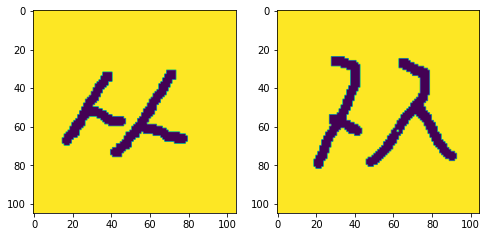

In [ ]:
import matplotlib.pyplot as plt

def show_image(image1, image2):
    plt.figure(figsize=(8, 4))
    plt.grid(False)
    plt.subplot(1,2,1)
    plt.imshow(image1)
    plt.subplot(1,2,2)
    plt.imshow(image2)
    plt.show()

    # show images at this index
show_image(train_X[664][2], train_X[664][0])

30개의 다른 알파벳에서 964개의 문자, 20개의 이미지, 105 x 105의 회색 이미지이며 총 이미지 19280(964 * 30)개를 사용한다. 

In [ ]:
def create_pairs_train(X, dataset_size):
    pairs = []
    labels = []
    for i in range(dataset_size):
        rand_num_class_first = np.random.randint(0,X.shape[0])
        rand_num_img_first = np.random.randint(0,X.shape[1])
        first_image = X[rand_num_class_first][rand_num_img_first]
        
        if(np.random.rand() > 0.5):
            rand_num_class_second = rand_num_class_first
            labels.append(1.0)
        
        else:
            rand_num_class_second = np.random.randint(0,X.shape[0])
            while(rand_num_class_second == rand_num_class_first):
                rand_num_class_second = np.random.randint(0,X.shape[0])
            labels.append(0.0)
                
        rand_num_img_second = np.random.randint(0,X.shape[1])
            
        while(rand_num_img_second == rand_num_img_first):
            rand_num_img_second = np.random.randint(0,X.shape[1])
            
        second_image = X[rand_num_class_second][rand_num_img_second]
        pairs.append([first_image, second_image])
        
    return pairs, labels
        
train_X_pair, train_y_pair = create_pairs_train(train_X, 30000)

In [ ]:
def create_pairs_val(X, dataset_size):
    pairs = []
    labels = []
    for i in range(dataset_size):
        rand_num_class_first = np.random.randint(0,X.shape[0])
        rand_num_img_first = np.random.randint(0,X.shape[1])
        first_image = X[rand_num_class_first][rand_num_img_first]
        
        if(np.random.rand() > 0.5):
            rand_num_class_second = rand_num_class_first
            labels.append(0.0)
        
        else:
            rand_num_class_second = np.random.randint(0,X.shape[0])
            while(rand_num_class_second == rand_num_class_first):
                rand_num_class_second = np.random.randint(0,X.shape[0])
            labels.append(1)
                
        rand_num_img_second = np.random.randint(0,X.shape[1])
            
        while(rand_num_img_second == rand_num_img_first):
            rand_num_img_second = np.random.randint(0,X.shape[1])
            
        second_image = X[rand_num_class_second][rand_num_img_second]
        pairs.append([first_image, second_image])
        
    return pairs, labels
        
val_X_pair, val_y_pair = create_pairs_val(val_X, 10000)

In [ ]:
a = np.array(val_y_pair,dtype=np.float64)
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{0.0: 5001, 1.0: 4999}

(Xi,Yi)를 가지고 있는 데이터 셋에서 어떻게 매핑 할 것인지 생각해보자. Xi는 입력,Yi는 출력을 나타낸다.

Xi = 이미지의 쌍 , Yi= 1, 인 경우 두 이미지는 비슷한 문자를 가지고 있다. Yi= 0, 인 경우 두 이미지는 다른 문자를 가지고 있다.

batch_size를 통해 함수를 호출해야 하며, batch_size 수만큼 이미지의 쌍을 반환한다.



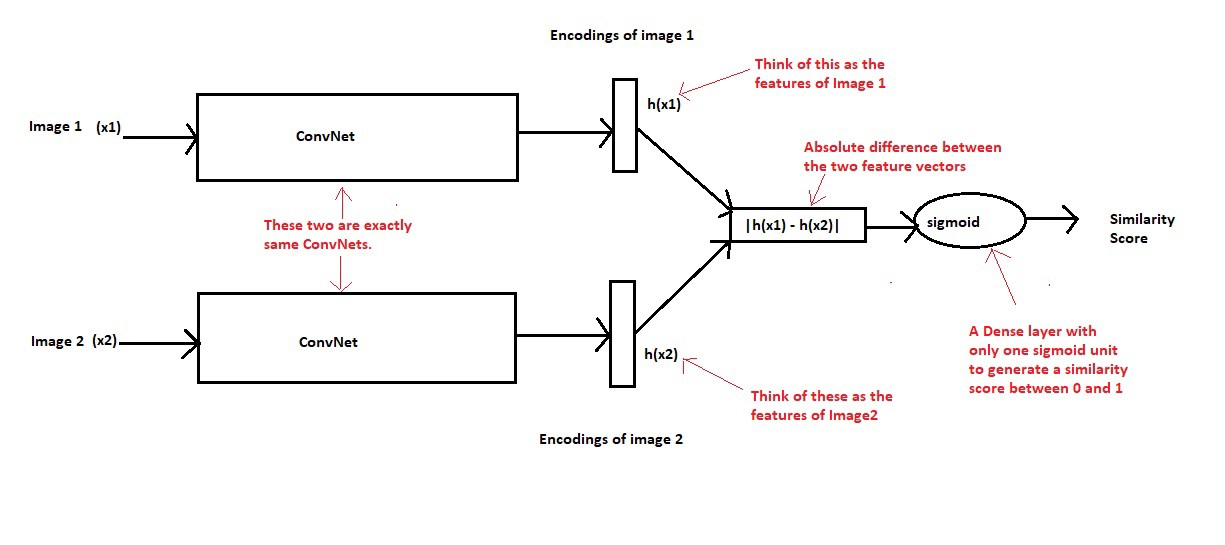

In [ ]:
from IPython.display import Image
Image("explain image/모델구조.jpg")

Convolutional Neural Networks는 다른 네트워크가 아닌 동일한 네트워크이다. 매개 변수 값을 공유한다. x1과 x2 두개의 이미지가 ConvNet을 지나 각각의 fixed length feature vector를 생성한다.  
  neural network 모델이 훈련이 잘되어 있다고 가정한다면, 두개의 입력 이미지가 같은 문자라면 feature vectors 또한 비슷하다. 두개의 이미지가 다른 문자라면 feature vectors 는 차이가 있다.   
  그래서 두 이미지의 feature vectors는 위와 같은 경우에 분명히 차이가 있어야하며, sigmoid layer층에서 생성된 유사성 점수도 차이가 있어야한다.

In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def base_network():
    input = Input(shape=(train_X.shape[2],train_X.shape[3],train_X.shape[4]), name='base_input')
    x = Conv2D(64, kernel_size = (10, 10), 
                 activation = 'relu')(input)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, kernel_size = (7, 7), 
                 activation = 'relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, kernel_size = (4, 4), 
                 activation = 'relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(256, kernel_size = (4, 4), 
                 activation = 'relu')(x) 
    x = Flatten(name='flatten_input')(x)
   
    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))

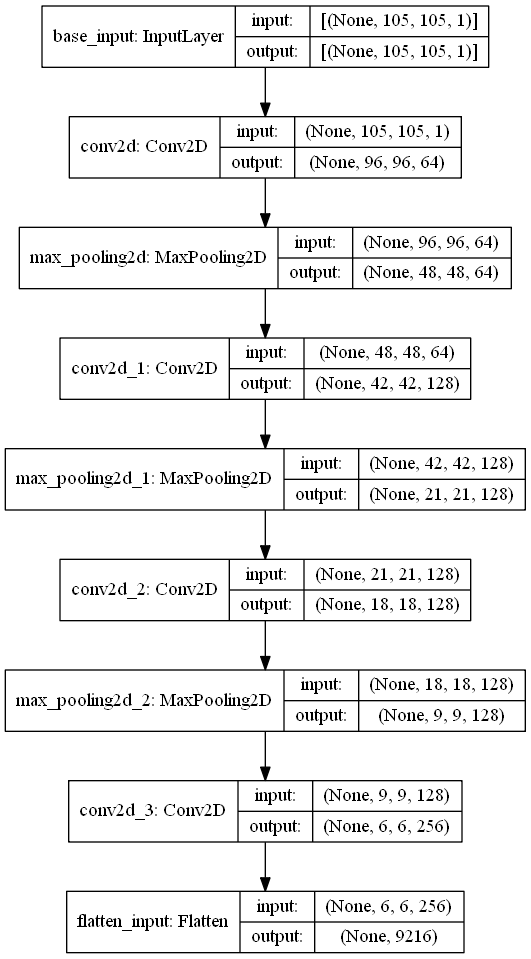

In [ ]:
from tensorflow.keras.utils import plot_model
base_model = base_network()
plot_model(base_model, show_shapes=True, show_layer_names=True)

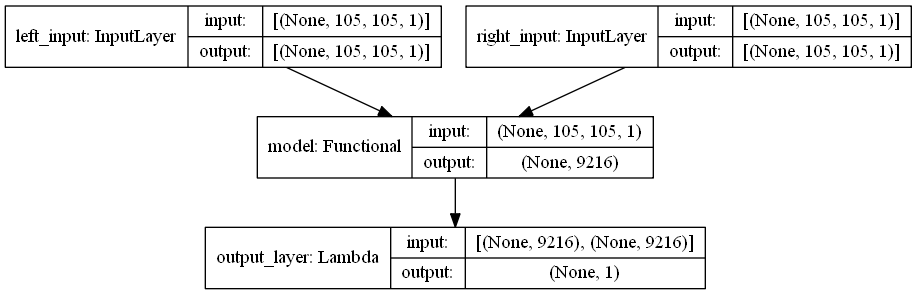

In [ ]:
from tensorflow.keras.layers import Lambda

input_a = Input(shape=(train_X.shape[2],train_X.shape[3],train_X.shape[4]), name='left_input')
vector_output_a = base_model(input_a)
input_b = Input(shape=(train_X.shape[2],train_X.shape[3],train_X.shape[4]), name='right_input')
vector_output_b = base_model(input_b)
output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])
# define model
model = Model([input_a, input_b], output)
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

    return contrastive_loss

model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=RMSprop())
history = model.fit([np.array(train_X_pair)[:, 0, :,:,:] , np.array(train_X_pair)[:, 1, :,:,:]] , np.array(train_y_pair,dtype=np.float64), 
                    epochs=40, batch_size = 64, callbacks= [ ],
                    validation_data=([np.array(val_X_pair)[:,0,:,:,:] , np.array(val_X_pair)[:, 1, :,:,:]] , np.array(val_y_pair,dtype=np.float64) ) )    
                               

Epoch 1/40
469/469 [==============================] - 111s 221ms/step - loss: 0.1972 - val_loss: 0.4479
Epoch 2/40
469/469 [==============================] - 104s 222ms/step - loss: 0.1807 - val_loss: 0.5364
Epoch 3/40
469/469 [==============================] - 104s 223ms/step - loss: 0.1781 - val_loss: 0.5647
Epoch 4/40
469/469 [==============================] - 102s 219ms/step - loss: 0.1708 - val_loss: 0.3786
Epoch 5/40
469/469 [==============================] - 106s 226ms/step - loss: 0.1556 - val_loss: 0.3889
Epoch 6/40
469/469 [==============================] - 103s 220ms/step - loss: 0.1420 - val_loss: 0.4518
Epoch 7/40
469/469 [==============================] - 104s 222ms/step - loss: 0.1334 - val_loss: 0.4692
Epoch 8/40
469/469 [==============================] - 106s 227ms/step - loss: 0.1238 - val_loss: 0.4191
Epoch 9/40
469/469 [==============================] - 104s 222ms/step - loss: 0.1164 - val_loss: 0.4576
Epoch 10/40
469/469 [==============================] - 109s 232m

In [ ]:
test_folder = 'evaluation_folder/images_evaluation/'

test_X, test_y ,c_test=loadimgs(test_folder)

loading alphabet: Atemayar_Qelisayer
loading alphabet: Aurek-Besh
loading alphabet: Ge_ez
loading alphabet: Gurmukhi
loading alphabet: Keble
loading alphabet: Manipuri
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Sylheti
loading alphabet: Tengwar
loading alphabet: ULOG


In [ ]:
test_X = np.expand_dims(test_X, axis=-1)

In [ ]:
import random

def create_pairs_20_shots(X, dataset_size):
    pairs = []
    
    for i in range(dataset_size):
               
        class_nums = random.sample(range(0,X.shape[0]), 20)
        rand_num_img_first = np.random.randint(0,X.shape[1])
        first_image = X[class_nums[0]][rand_num_img_first]
        
        rand_num_img_second = np.random.randint(0,X.shape[1])
        if(rand_num_img_first == rand_num_img_second):
            rand_num_img_second = np.random.randint(0,X.shape[1])
            
        second_image = X[class_nums[0]][rand_num_img_second]
        pairs.append([first_image,second_image])
        
        for j in range(1,20):
            temp_image = X[class_nums[j]][np.random.randint(0,X.shape[1])]
            pairs.append([first_image,temp_image])
            
          
        
    return pairs
        
test_X_pair = create_pairs_20_shots(test_X, 1000)

In [ ]:
y_pred= model.predict([np.array(test_X_pair)[:, 0, :,:,:] , np.array(test_X_pair)[:, 1, :,:,:]])
y_pred = y_pred.reshape(-1,20)

In [ ]:
result = []

for i in range(y_pred.shape[0]):
    if (y_pred[i].min() == y_pred[i][0]):
        result.append(1.0)
    else:
        result.append(0.0)

In [ ]:
score = np.mean(result)
score

0.59

In [ ]:
len(result)

1000

In [ ]:
y_pred[0]

array([0.24573739, 0.77634275, 0.9278786 , 1.0383145 , 0.8486777 ,
       0.89181846, 0.8998823 , 1.2144431 , 0.63829607, 1.1523386 ,
       0.75506574, 0.9222673 , 1.0207953 , 0.78745776, 1.0015931 ,
       1.0224913 , 1.0493814 , 0.6761904 , 1.1116363 , 0.9681821 ],
      dtype=float32)

In [ ]:
result[0]

1.0

In [ ]:
model.save('omniglot.h5')